# BM25 Evaluation

In [1]:
%load_ext autoreload
%autoreload 2
import json
import sys
import os
import logging
import pickle
import random
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from wordcloud import WordCloud


from tqdm.notebook import tqdm
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from evaluation import *
from preprocessing import Corpus, BasicPreprocessing, BigramPreprocessor, SpacyPreprocessor, StopWordPreprocessor
from retrieval_algorithms import BM25RetrievalAlgorithm
from retrieval_algorithms.prf_wrapper import PRFWrapper
from retrieval_algorithms.ontology_expansion_wrapper import OntologyExpansionWrapper

## Load corpus using different preprocessing pipelines

In [2]:
base_file =  "../../data/kit_expert_2019_all_papers.csv"

p = [BasicPreprocessing(), StopWordPreprocessor()]
papers_basic = Corpus(base_file, p)

p = [BasicPreprocessing(), StopWordPreprocessor(), SpacyPreprocessor(lemmatization="all")]
papers_basic_lemmatization_all = Corpus(base_file, p, load_from_cache=True, n_jobs=16)

p = [BasicPreprocessing(), StopWordPreprocessor(), SpacyPreprocessor(lemmatization="nouns")]
papers_basic_lemmatization_nouns = Corpus(base_file, p, load_from_cache=True, n_jobs=16)

INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_NoStopWords" for file ../../data/kit_expert_2019_all_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../../data/kit_expert_2019_all_papers_basic_NoStopWords
INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_NoStopWords_spacy_lemmatization_all" for file ../../data/kit_expert_2019_all_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../../data/kit_expert_2019_all_papers_basic_NoStopWords_spacy_lemmatization_all
INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_NoStopWords_spacy_lemmatization_nouns" for file ../../data/kit_expert_2019_all_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../../data/kit_expert_2019_all_papers_basic_NoStopWords_spacy_lemmatization_nouns


## Load keywords to use as test data

In [3]:
with open("../../data/kit_expert_2019_all_keywords.json", "r") as file:
    keywords = json.load(file)

In [4]:
general_keywords = [k for k in keywords if k["level"]<=1]
specific_keywords = [k for k in keywords if k["level"]>=2 and len(k["paper_ids"])>=10]

general_keywords_val = ("general keywords validation", general_keywords[0:int(len(general_keywords)*0.8)])
specific_keywords_val = ("specific keywords validation", specific_keywords[0:int(len(specific_keywords)*0.8)])
general_keywords_test = ("general keywords test", general_keywords[int(len(general_keywords)*0.8):])
specific_keywords_test = ("specific keywords test", specific_keywords[int(len(specific_keywords)*0.8):])

## Grid search for BM25 k1 parameter

In [7]:
k1_grid = np.arange(0.1,2.1,0.1)
search_k1_bm25_models = [(f"BM25 k1={k1:.2f}", BM25RetrievalAlgorithm(k1=k1, b=0.5), papers_basic) for k1 in k1_grid]

In [ ]:
%%time
search_k1_bm25_results = train_evaluate_models(search_k1_bm25_models, [general_keywords_val, specific_keywords_val], n_jobs=10)#len(search_k1_bm25_models))

In [11]:
search_k1_bm25_results.to_csv("../../data/results/search_k1_bm25_results.csv")

In [5]:
search_k1_bm25_results = pd.read_csv("../../data/results/search_k1_bm25_results.csv", index_col=0, header=[0,1,2])

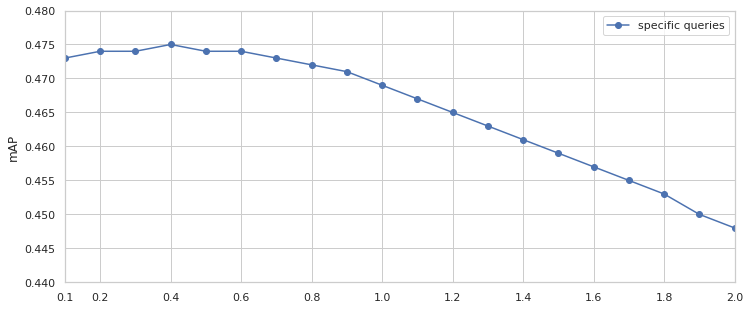

In [21]:
plot_data = search_k1_bm25_results["specific keywords validation"]["mAP"]["avg"]
err_data = search_k1_bm25_results["specific keywords validation"]["mAP"]["err"]
plot_data.index = k1_grid
ax = plot_data.plot(label="specific queries", figsize=(12,5), style="-bo", legend=False, xticks=[0.1]+list(np.arange(0,2.2,0.2)), xlim=(0.1,2.), ylim=(0.44,0.48))
ax.set_ylabel("mAP");
# plt.fill_between(plot_data.index, plot_data.values-err_data.values, plot_data.values+err_data.values,
#     alpha=0.2, edgecolor='blue', facecolor='lightblue',
#     linewidth=1)
ax.legend(loc="upper right")
plt.savefig("images/bm25_k1_search.pdf", transparent=True, bbox_inches="tight")

Results:
- k1 of 0.4 has the best performance

## Grid search for BM25 b parameter

In [17]:
b_grid = np.arange(0.0,1.1,0.1)
search_b_bm25_models = [(f"BM25 b={b:.2f}", BM25RetrievalAlgorithm(b=b, k1=0.4), papers_basic) for b in b_grid]

In [ ]:
%%time
search_b_bm25_results = train_evaluate_models(search_b_bm25_models, [general_keywords_val, specific_keywords_val], n_jobs=len(search_b_bm25_models))

In [ ]:
search_b_bm25_results.to_csv("../../data/results/search_b_bm25_results.csv")

In [18]:
search_b_bm25_results = pd.read_csv("../../data/results/search_b_bm25_results.csv", index_col=0, header=[0,1,2])
search_b_bm25_results

general keywords validation                                                                              specific keywords validation                                                                             
                                    p@5          p@10          p@20        R-prec           mAP         bpref                                 p@5          p@10          p@20        R-prec           mAP         bpref       
                                    avg    err    avg    err    avg    err    avg    err    avg    err    avg    err                          avg    err    avg    err    avg    err    avg    err    avg    err    avg    err
BM25 b=0.00                       0.287  0.041  0.238  0.034  0.202  0.030  0.072  0.012  0.039  0.008  0.055  0.009                        0.621  0.008  0.567  0.008  0.482  0.007  0.454  0.006  0.452  0.007  0.436  0.007
BM25 b=0.10                       0.292  0.041  0.244  0.034  0.209  0.031  0.073  0.012  0.039  0.008  0.056  0.010                        0.635  0.008  0.582  0.008  0.493  0.007  0.468  0.006  0.467  0.007  0.452  0.007
BM25 b=0.20                       0.290  0.041  0.246  0.034  0.209  0.031  0.073  0.012  0.040  0.008  0.056  0.010                        0.639  0.008  0.586  0.008  0.495  0.007  0.470  0.006  0.469  0.007  0.454  0.007
BM25 b=0.30                       0.291  0.041  0.247  0.035  0.211  0.031  0.073  0.012  0.040  0.008  0.056  0.010                        0.643  0.008  0.589  0.008  0.497  0.007  0.471  0.006  0.471  0.007  0.456  0.007
BM25 b=0.40                       0.292  0.041  0.247  0.034  0.212  0.031  0.073  0.012  0.040  0.008  0.056  0.010                        0.645  0.008  0.591  0.008  0.499  0.007  0.473  0.006  0.473  0.007  0.457  0.007
BM25 b=0.50                       0.295  0.041  0.245  0.034  0.213  0.031  0.075  0.012  0.040  0.008  0.057  0.010                        0.649  0.008  0.593  0.008  0.500  0.007  0.474  0.006  0.475  0.007  0.459  0.007
BM25 b=0.60                       0.298  0.041  0.250  0.035  0.214  0.031  0.073  0.012  0.040  0.008  0.056  0.010                        0.652  0.008  0.595  0.008  0.501  0.007  0.475  0.006  0.476  0.007  0.460  0.007
BM25 b=0.70                       0.298  0.042  0.253  0.036  0.213  0.031  0.073  0.012  0.040  0.008  0.056  0.010                        0.652  0.008  0.595  0.008  0.501  0.007  0.475  0.006  0.476  0.007  0.461  0.007
BM25 b=0.80                       0.289  0.041  0.254  0.036  0.211  0.031  0.074  0.012  0.040  0.008  0.057  0.010                        0.651  0.008  0.596  0.008  0.501  0.007  0.476  0.006  0.477  0.007  0.461  0.007
BM25 b=0.90                       0.288  0.041  0.252  0.035  0.209  0.030  0.074  0.012  0.040  0.008  0.057  0.010                        0.651  0.008  0.595  0.008  0.501  0.007  0.476  0.006  0.476  0.007  0.461  0.007
BM25 b=1.00                       0.288  0.041  0.253  0.035  0.208  0.030  0.073  0.012  0.040  0.008  0.056  0.010                        0.650  0.008  0.593  0.008  0.500  0.007  0.476  0.006  0.475  0.007  0.460  0.007

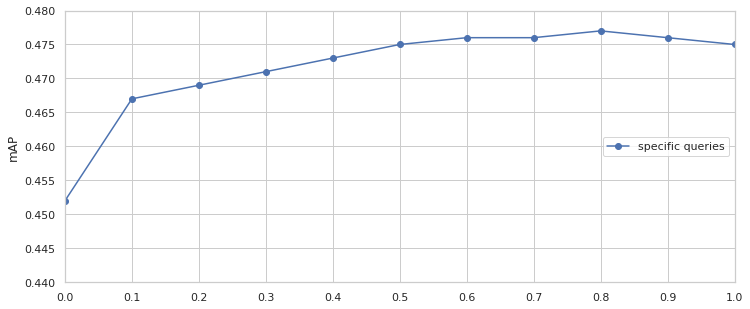

In [20]:
plot_data = search_b_bm25_results["specific keywords validation"]["mAP"]["avg"]
err_data = search_b_bm25_results["specific keywords validation"]["mAP"]["err"]
plot_data.index = b_grid
ax = plot_data.plot(label="specific queries", figsize=(12,5), style="-bo", legend=False, xticks=np.arange(0,1.1,0.1), xlim=(0,1.0), ylim=(0.44,0.48))
ax.set_ylabel("mAP");
# plt.fill_between(plot_data.index, plot_data.values-err_data.values, plot_data.values+err_data.values,
#     alpha=0.2, edgecolor='blue', facecolor='lightblue',
#     linewidth=1)
ax.legend(loc="center right")
plt.savefig("images/bm25_b_search.pdf", transparent=True, bbox_inches="tight")

Results:
- b parameter does not have a great effect on model performance
- best value at 0.8

## Test bm25 with best parameters on n-grams

In [ ]:
ngram_bm25_models = [
    ("bm25 1-gram", BM25RetrievalAlgorithm(max_ngram=1, k1=0.4, b=0.8), papers_basic_lemmatization_nouns),
    ("bm25 2-gram", BM25RetrievalAlgorithm(max_ngram=2, k1=0.4, b=0.8), papers_basic_lemmatization_nouns),
    ("bm25 3-gram", BM25RetrievalAlgorithm(max_ngram=3, k1=0.4, b=0.8), papers_basic_lemmatization_nouns),
    ("bm25 4-gram", BM25RetrievalAlgorithm(max_ngram=4, k1=0.4, b=0.8), papers_basic_lemmatization_nouns),
]

In [ ]:
ngram_bm25_results = train_evaluate_models(ngram_bm25_models, [general_keywords_val, specific_keywords_val], n_jobs=4)

In [67]:
ngram_bm25_results.to_csv("../../data/results/ngram_bm25_results.csv")
ngram_bm25_results

general keywords validation                                                                             specific keywords validation                                                                             
                                    p@5          p@10          p@20        R-prec           mAP         bpref                                p@5          p@10          p@20        R-prec           mAP         bpref       
                                    avg    err    avg    err    avg    err    avg    err    avg    err    avg   err                          avg    err    avg    err    avg    err    avg    err    avg    err    avg    err
bm25 1-gram                       0.285  0.041  0.246  0.035  0.210  0.030  0.077  0.013  0.041  0.008  0.058  0.01                        0.646  0.008  0.590  0.008  0.500  0.007  0.476  0.006  0.482  0.007  0.462  0.007
bm25 2-gram                       0.299  0.040  0.252  0.034  0.212  0.030  0.078  0.013  0.043  0.008  0.060  0.01                        0.732  0.008  0.674  0.007  0.566  0.007  0.551  0.006  0.561  0.007  0.547  0.007
bm25 3-gram                       0.299  0.040  0.252  0.034  0.211  0.030  0.078  0.013  0.044  0.008  0.060  0.01                        0.732  0.008  0.674  0.007  0.566  0.007  0.551  0.006  0.560  0.007  0.547  0.007
bm25 4-gram                       0.299  0.040  0.252  0.034  0.212  0.031  0.078  0.013  0.044  0.008  0.060  0.01                        0.731  0.008  0.672  0.007  0.565  0.007  0.550  0.006  0.559  0.007  0.546  0.007

Results:
- bigrams improve result of bm25
- bm25 bigram model achieves best score on specific keywords
- general keyword score still very low

## Visualize pseudo relevance feedback

In [12]:
best_bm25_model = BM25RetrievalAlgorithm(max_ngram=2, k1=0.4, b=0.8)
best_bm25_model.prepare(papers_basic_lemmatization_nouns)

In [49]:
prf = PRFWrapper(best_bm25_model, 150, 30, 0.5, 1)
prf.prepare(papers_basic_lemmatization_nouns)

In [12]:
prf.num_expansion_terms=30
# prf.num_relevant_docs=150

In [13]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % ((1-(font_size/130))*40+5)

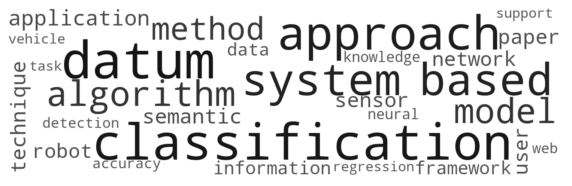

In [14]:
wordcloud = WordCloud(
    width=1300,
    height=400,
    background_color="white",
    color_func=grey_color_func,
    max_font_size=120,
    min_font_size=20,
    random_state=3,
    margin=5
).fit_words(prf.get_expansion_terms("machine learning"))
plt.figure(figsize = (10,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");
wordcloud.to_file("images/bm25_prf_machinelearning_wordcloud.png");

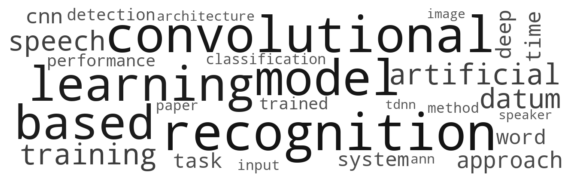

In [15]:
wordcloud = WordCloud(
    width=1300,
    height=400,
    background_color="white",
    color_func=grey_color_func,
    max_font_size=120,
    min_font_size=20,
    random_state=2,
    margin=5
#     colormap="Paired"
).fit_words(prf.get_expansion_terms("neural network"))
plt.figure(figsize = (10,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");
wordcloud.to_file("images/bm25_prf_neuralnetwork_wordcloud.png");

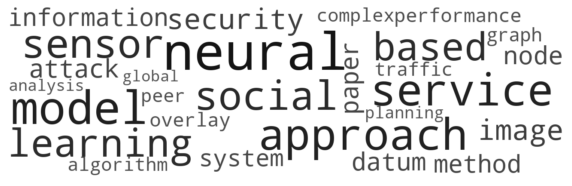

In [16]:
wordcloud = WordCloud(
    width=1300,
    height=400,
    background_color="white",
    color_func=grey_color_func,
    max_font_size=120,
    min_font_size=20
#     colormap="Paired"
).fit_words(prf.get_expansion_terms("generative adversarial network"))
plt.figure(figsize = (10,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");
wordcloud.to_file("images/bm25_prf_generativeadversarialnetwork_wordcloud.png");

## Evaluate pseudo relevance feedback

In [ ]:
prf_grid = [(150,200,np.round(i,3)) for i in np.linspace(0,1,21)]
search_prf_models = [(f"prf nrd={nrd:.2f} net={net:.2f} ew={ew:.2f}", PRFWrapper(best_bm25_model, nrd, net, ew), papers_basic_lemmatization_nouns) for nrd, net, ew in prf_grid]

In [ ]:
search_prf_results = train_evaluate_models(search_prf_models, [general_keywords_val, specific_keywords_val], n_jobs=12)

In [ ]:
search_prf_results.to_csv("../../data/results/bm25_search_prf_results.csv")

In [2]:
search_prf_results = pd.read_csv("../../data/results/bm25_search_prf_results.csv", index_col=0, header=[0,1,2])

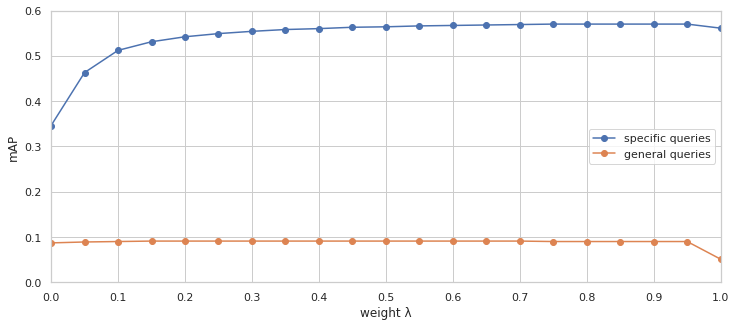

In [6]:
plot_data = search_prf_results.xs('mAP', level=1, axis=1).xs('avg', level=1, axis=1)
err_data = search_prf_results.xs('mAP', level=1, axis=1).xs('err', level=1, axis=1)
plot_data.index = np.linspace(0,1,21)
ax = plot_data.iloc[:,1].plot(label="specific queries", figsize=(12,5), style="-o", legend=True, xticks=[0]+np.linspace(0,1,11), xlim=(0,1), yticks=np.arange(0,1,0.1), ylim=(0.0,0.6))
ax = plot_data.iloc[:,0].plot(label="general queries", figsize=(12,5), style="-o", legend=True, xticks=[0]+np.linspace(0,1,11), xlim=(0,1), yticks=np.arange(0,1,0.1), ylim=(0.0,0.6))
ax.set_ylabel("mAP");
ax.set_xlabel("weight λ")
# plt.fill_between(plot_data.index, plot_data.iloc[:,1].values-err_data.iloc[:,1].values, plot_data.iloc[:,1].values+err_data.iloc[:,1].values,
#     alpha=0.4, edgecolor=sns.color_palette("Blues")[3], facecolor=sns.color_palette("Blues")[1], linewidth=1)
# plt.fill_between(plot_data.index, plot_data.iloc[:,0].values-err_data.iloc[:,0].values, plot_data.iloc[:,0].values+err_data.iloc[:,0].values,
#     alpha=0.4, edgecolor=sns.color_palette("Oranges")[3], facecolor=sns.color_palette("Oranges")[1], linewidth=1)
plt.savefig("images/bm25_prf.pdf", transparent=True, bbox_inches="tight")

## Ontology Query Expansion

In [14]:
with open("../../data/keyword_hierarchy.json", 'r') as file:
    keyword_hierarchy = json.load(file)

In [27]:
oqe_grid = [np.round(i,3) for i in np.linspace(0,1,21)]
search_oqe_models = [(f"ontology expansion wrapper w={ew}", OntologyExpansionWrapper(best_bm25_model, keyword_hierarchy, True, ew), papers_basic_lemmatization_nouns) for ew in oqe_grid]

In [ ]:
search_oqe_results = train_evaluate_models(search_oqe_models, [general_keywords_val, specific_keywords_val], n_jobs=5)

In [ ]:
search_oqe_results.to_csv("../../data/results/bm25_search_oqe_results.csv")

In [25]:
search_oqe_results = pd.read_csv("../../data/results/bm25_search_oqe_results.csv", index_col=0, header=[0,1,2])

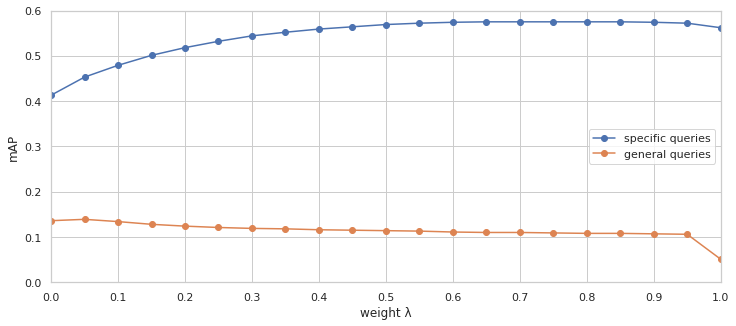

In [26]:
plot_data = search_oqe_results.xs('mAP', level=1, axis=1).xs('avg', level=1, axis=1)
err_data = search_oqe_results.xs('mAP', level=1, axis=1).xs('err', level=1, axis=1)
plot_data.index = np.linspace(0,1,21)
ax = plot_data.iloc[:,1].plot(label="specific queries", figsize=(12,5), style="-o", legend=True, xticks=[0]+np.linspace(0,1,11), xlim=(0,1), ylim=(0.0,0.6))
ax = plot_data.iloc[:,0].plot(label="general queries", figsize=(12,5), style="-o", legend=True, xticks=[0]+np.linspace(0,1,11), xlim=(0,1), ylim=(0.0,0.6))
ax.set_ylabel("mAP");
ax.set_xlabel("weight λ")
ax.legend(loc="center right")
# plt.fill_between(plot_data.index, plot_data.iloc[:,1].values-err_data.iloc[:,1].values, plot_data.iloc[:,1].values+err_data.iloc[:,1].values,
#     alpha=0.4, edgecolor=sns.color_palette("Blues")[3], facecolor=sns.color_palette("Blues")[1], linewidth=1)
# plt.fill_between(plot_data.index, plot_data.iloc[:,0].values-err_data.iloc[:,0].values, plot_data.iloc[:,0].values+err_data.iloc[:,0].values,
#     alpha=0.4, edgecolor=sns.color_palette("Oranges")[3], facecolor=sns.color_palette("Oranges")[1], linewidth=1)
plt.savefig("images/bm25_oqe.pdf", transparent=True, bbox_inches="tight")

In [38]:
bm25_oqe_model = OntologyExpansionWrapper(best_bm25_model, keyword_hierarchy, True, 0.9)
bm25_oqe_model.prepare(papers_basic)
file_path = "../../data/models/tfidf/bm25_oqe.model"
with open(file_path, "wb") as file:
    pickle.dump(bm25_oqe_model, file)